In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## 1. Temporal partitioning

In [11]:
trn_crd = pd.read_csv('LWAT01_trncrd.csv', header=None, usecols=[0, 1])
trn_crd.head()

,0,1
0,0.076851,0.894201
1,0.076847,0.894169
2,0.076953,0.894230
3,0.076847,0.894158
4,0.076983,0.894148


In [12]:
trn_rss = pd.read_csv('LWAT01_trnrss.csv', header=None)
trn_rss.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-200,-200,-200,-200,-99,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-200,-95,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-107,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-90,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-103,-98,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [13]:
tst_crd = pd.read_csv('LWAT01_tstcrd.csv', header=None, usecols=[0, 1])
tst_crd.head()

,0,1
0,0.076948,0.894150
1,0.076856,0.894155
2,0.076833,0.894133
3,0.076775,0.894027
4,0.076723,0.893950


In [14]:
tst_rss = pd.read_csv('LWAT01_tstrss.csv', header=None)
tst_rss.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-200,-200,-200,-115,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-200,-91,-109,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-96,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-100,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-200,-109,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


### 1.1 EDA

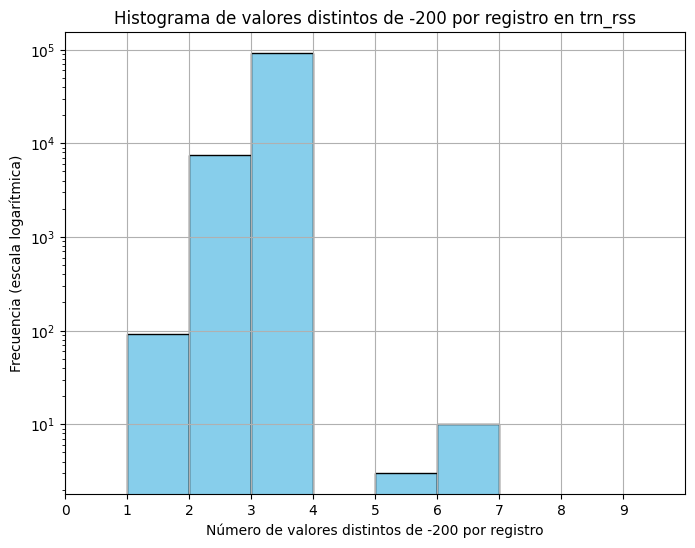

In [ ]:
# Calcular la cantidad de valores distintos de -200 por registro
num_valid_values_per_record = np.sum(trn_rss != -200, axis=1)

# Crear el histograma con escala logarítmica en el eje y
plt.figure(figsize=(8, 6))
plt.hist(num_valid_values_per_record, bins=np.arange(0, trn_rss.shape[1]+1), color='skyblue', edgecolor='black', log=True)
plt.xlabel('Número de valores distintos de -200 por registro')
plt.ylabel('Frecuencia (escala logarítmica)')
plt.title('Histograma de valores distintos de -200 por registro en trn_rss')
plt.xlim(0, 10)
plt.xticks(np.arange(10))
plt.grid(True)
plt.show()

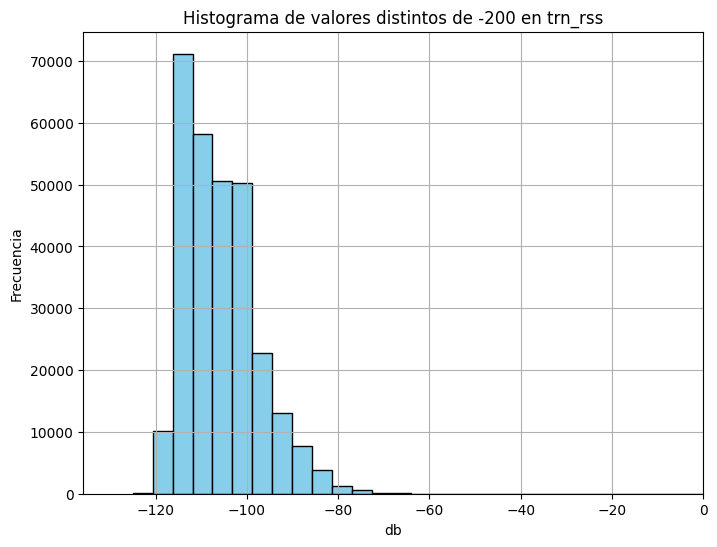

In [ ]:
# Obtener los valores distintos de -200 en trn_rss
values = trn_rss.values.flatten()
values = values[values != -200]

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('db')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores distintos de -200 en trn_rss')
plt.xlim(right=0)
plt.grid(True)
plt.show()

### 1.2 KNN-based fingerprinting

In [6]:
# Función para calcular la distancia euclidiana entre dos puntos
def haversine(coord1, coord2):
    # Radio de la Tierra en metros
    R = 6371000

    lon1, lat1 = coord1
    lon2, lat2 = coord2

    # Diferencia de coordenadas
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Calcular la distancia usando la fórmula del haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

In [ ]:
# Crear el modelo k-NN
def knn_fingerprinting(k):
  knn_model = KNeighborsRegressor(n_neighbors=k)
  knn_model.fit(trn_rss, trn_crd)

  # Predecir los RSSI para los datos de prueba
  predicted_crd = knn_model.predict(tst_rss)

  # Convertimos a array
  tst_crd_array = np.array(tst_crd)

  # Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
  distances = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

  # Calcular el error medio
  mean_error = np.mean(distances)

  return "Error medio: " + str(np.round(mean_error, 2)) + " m"

In [ ]:
knn_fingerprinting(k=3)

'Error medio: 504.44 m'

In [ ]:
knn_fingerprinting(k=12)

'Error medio: 475.8 m'

### 1.3 DL-based fingerprinting

1.3.1 FCN

In [ ]:
# Definir la arquitectura de la red neuronal
class FingerprintingNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)  # Salida de 2 dimensiones para las coordenadas (longitud, latitud)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)

# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 100
model = FingerprintingNN(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
#criterion = nn.MSELoss()
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)
    predicted_crd = predicted_crd_tensor.numpy()
    tst_crd_array = tst_crd.values


# Calcular la distancia haversine entre las coordenadas predichas y las reales
distances = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Calcular el error medio
mean_error = np.mean(distances)

# Imprimir el error medio
print("Error medio (distancia haversine):", mean_error)

Epoch [10/100], Loss: 2869509.0000
Epoch [20/100], Loss: 1233051.3750
Epoch [30/100], Loss: 755962.1875
Epoch [40/100], Loss: 503062.0000
Epoch [50/100], Loss: 408081.9688
Epoch [60/100], Loss: 340580.2188
Epoch [70/100], Loss: 293215.6562
Epoch [80/100], Loss: 252024.8125
Epoch [90/100], Loss: 216832.1250
Epoch [100/100], Loss: 187578.0000
Error medio (distancia haversine): 241227.01965229935


1.3.2 LSTM

In [15]:
# Definir la arquitectura de la red neuronal

class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 100
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
#criterion = nn.MSELoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)
    predicted_crd = predicted_crd_tensor.numpy()
    min_lon = min(tst_crd[0])
    max_lon = max(tst_crd[0])
    min_lat = min(tst_crd[1])
    max_lat = max(tst_crd[1])
    predicted_crd[:, 0] = predicted_crd[:, 0] * (max_lon - min_lon) + min_lon
    predicted_crd[:, 1] = predicted_crd[:, 1] * (max_lat - min_lat) + min_lat
    tst_crd_array = tst_crd.values


# Calcular la distancia haversine entre las coordenadas predichas y las reales
distances = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Calcular el error medio
mean_error = np.mean(distances)

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

Epoch [10/100], Loss: 0.1184
Epoch [20/100], Loss: 0.0077
Epoch [30/100], Loss: 0.0031
Epoch [40/100], Loss: 0.0028
Epoch [50/100], Loss: 0.0013
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002
Error medio (distancia haversine): 5864.73 m


LSTM 2

Epoch [1/100], Training Loss: 514719.8554, Validation Loss: 22705.0391
Epoch [2/100], Training Loss: 82094.5375, Validation Loss: 14993.9219
Epoch [3/100], Training Loss: 71011.7359, Validation Loss: 10765.8955
Epoch [4/100], Training Loss: 64512.1699, Validation Loss: 9308.3281
Epoch [5/100], Training Loss: 59994.0645, Validation Loss: 10434.5059
Epoch [6/100], Training Loss: 57659.6485, Validation Loss: 7975.9683
Epoch [7/100], Training Loss: 55424.7349, Validation Loss: 11814.7217
Epoch [8/100], Training Loss: 53761.8193, Validation Loss: 11640.8594
Epoch [9/100], Training Loss: 52278.7863, Validation Loss: 9573.7734
Epoch [10/100], Training Loss: 50578.0204, Validation Loss: 8593.1475
Epoch [11/100], Training Loss: 49279.6321, Validation Loss: 7288.9380
Epoch [12/100], Training Loss: 47881.6138, Validation Loss: 8332.7236
Epoch [13/100], Training Loss: 46397.2323, Validation Loss: 8035.1206
Epoch [14/100], Training Loss: 45134.3678, Validation Loss: 7282.2988
Epoch [15/100], Traini

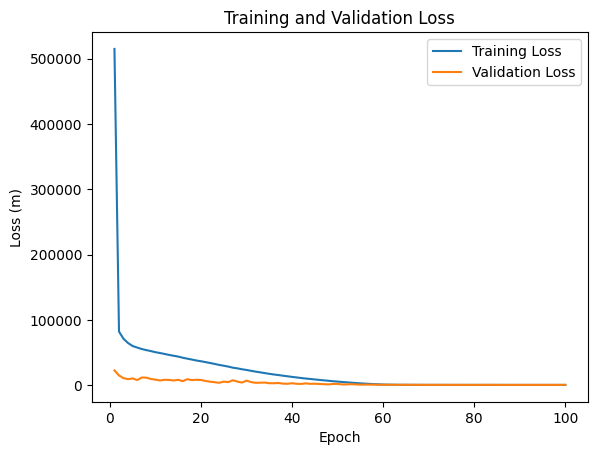

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [20]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)
    predicted_crd = predicted_crd_tensor.numpy()
    min_lon = min(tst_crd[0])
    max_lon = max(tst_crd[0])
    min_lat = min(tst_crd[1])
    max_lat = max(tst_crd[1])
    predicted_crd[:, 0] = predicted_crd[:, 0] * (max_lon - min_lon) + min_lon
    predicted_crd[:, 1] = predicted_crd[:, 1] * (max_lat - min_lat) + min_lat
    tst_crd_array = tst_crd.values


# Calcular la distancia haversine entre las coordenadas predichas y las reales
distances = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Calcular el error medio
mean_error = np.mean(distances)

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

In [36]:
criterion(predicted_crd_tensor, tst_crd_tensor)

tensor(5861.2202)

## 2. Random partitioning

In [ ]:
# Se ejecuta el script 'LoRaWAN_random_split.py' para generar ficheros particionados aleatoriamente que se cargan a continuación
train_rss_random = pd.read_csv('train_rss_random.csv')
train_crd_random = pd.read_csv('train_crd_random.csv')
val_rss_random = pd.read_csv('val_rss_random.csv')
val_crd_random = pd.read_csv('val_crd_random.csv')

In [ ]:
train_rss_random.head()

,BS 1,BS 2,BS 3,BS 4,BS 5,BS 6,BS 7,BS 8,BS 9,BS 10,...,BS 59,BS 60,BS 61,BS 62,BS 63,BS 64,BS 65,BS 66,BS 67,BS 68
0,-103,-103,-200,-200,-200,-200,-200,-200,-200,-79,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-111,-92,-85,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-117,-200,-200,-200,-200,-200,-120,-109,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-98,-200,-200,-200,-200,-108,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [ ]:
train_crd_random.head()

,Longitude,Latitude
0,0.077119,0.893511
1,0.077238,0.893668
2,0.077709,0.893796
3,0.076969,0.893717
4,0.077164,0.893656


In [ ]:
val_rss_random.head()

,BS 1,BS 2,BS 3,BS 4,BS 5,BS 6,BS 7,BS 8,BS 9,BS 10,...,BS 59,BS 60,BS 61,BS 62,BS 63,BS 64,BS 65,BS 66,BS 67,BS 68
0,-200,-93,-105,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-112,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-104,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-200,-200,-200,-200,-200,-99,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [ ]:
val_crd_random.head()

,Longitude,Latitude
0,0.077189,0.893774
1,0.076781,0.894037
2,0.076878,0.894083
3,0.077135,0.894164
4,0.077427,0.894000


### 2.1 KNN-based fingerprinting (K=3)

In [ ]:
# Crear el modelo k-NN
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(train_rss_random, train_crd_random)

# Predecir los RSSI para los datos de prueba
predicted_crd_random = knn_model.predict(val_rss_random)

# Convertimos a array
val_crd_array_random = np.array(val_crd_random)

# Calcular la distancia euclidiana entre las coordenadas predichas y las coordenadas reales
distances_random = [haversine(pred, real) for pred, real in zip(predicted_crd_random, val_crd_array_random)]

# Calcular el error medio
mean_error_random = np.mean(distances_random)

# Imprimir el error medio
print("Error medio:", mean_error_random)

Error medio: 420.66445099883015
